# Creating a Camera Model
Here we load a previously created OREX POLYCAM ISD file and create a working camera model.

In [1]:
import json
import gdal
import pyproj
import numpy as np

# CSM Imports
from cycsm.isd import Isd
import usgscam as cam

# Load / Create the ISD

In [25]:
with open('A18111310005_PCAM_L2.isd', 'r') as f:
    i = Isd.load(f)

In [3]:
i.param('omega')

-1.5943142528879

# Create the Model
Like MDIS, we have a single model that covers 3 cameras.  If the cameras have different distortion models, we would register multiple models with the plugin.

In [4]:
plugin = cam.orex.ORexPlugin()
print('This plugin contains {} models.'.format(plugin.nmodels))
model = plugin.from_isd(i, plugin.modelname(1))

This plugin contains 1 models.


In [5]:
model

In [6]:
model.name

'UsgsAstroFrameMdisPluginCSM'

# Pixel Origin
This is a super fast test case, so I am not 100% sure I have the pixel origin in the right place, e.g. just skimmed the ik and could be off by 1/2 a pixel.

# Image to Ground and Ground to Image
These should be the inverse of each other.

In [9]:
model.imageToGround(511.5, 511.5, 0)

[-74.67332191668538, -272.36759350678767, 6.424928036312394]

In [10]:
model.groundToImage(-74.5349651380966, -272.3976393244229, 6.716675050491631)

[511.5, 511.5]

# Example SET
This is a pretty basic Senor Exploitation Tool to get the image pushed onto the surface.  Note that I am using a biaxial shape within the camera - triaxial would be better (on the camera side) and a 'real' SET would use the intersection information retured from the camera along with a shape model to iteratively find the 'true' surface intersection point.

In [12]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/jlaura/anaconda3/envs/camera/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


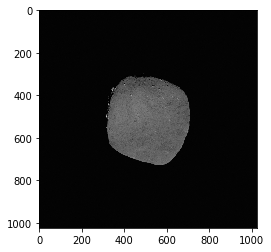

In [13]:
d = gdal.Open('/work/projects/OSIRIS-REx/ORIGINAL/A18111310005_PCAM_L2.cub')
arr = d.GetRasterBand(1).ReadAsArray()
imshow(arr, cmap='gray')

In [29]:
i.param('x_sensor_origin'), i.param('y_sensor_origin'), i.param('z_sensor_origin') 

(-23746.382688576374, -84555.78039612206, 868.1464518756829)

In [31]:
i.param('semi_a_axis'), i.param('semi_b_axis'), i.param('semi_b_axis')

(0.2825, 0.2675, 0.2675)

In [22]:
res = np.empty((arr.shape[0] * arr.shape[1], 4))
res[:,0] = arr.ravel()

size = model.imagesize
c = 0
for i in range(int(size[0])):
    for j in range(int(size[1])):
        x, y, z = model.imageToGround(i,j,0)
        idx = (i*j)
        res[c, 1] = x
        res[c, 2] = y
        res[c, 3] = z
        c += 1

In [16]:
import pandas as pd

In [39]:
# Again projecting onto an ellipsoid
df = pd.DataFrame(res, columns=['dn', 'x', 'y', 'z'])
#Setup to reproject
ecef = pyproj.Proj(proj='geocent', a=282, b=267)
lla = pyproj.Proj(proj='longlat', a=282, b=267)
x = df.x.values
y = df.y.values
z = df.z.values
lons, lats, alts = pyproj.transform(ecef, lla, x,y,z)

In [40]:
df = pd.DataFrame(np.vstack((lons, lats, df.dn.values)).T, columns=['longitude', 'latitude', 'dn'])
df.head(10)

,longitude,latitude,dn
0,166.156249,-66.109845,0.016344
1,166.147818,-66.032133,0.013780
2,166.139403,-65.953975,0.015581
3,166.131005,-65.875368,0.012379
4,166.122622,-65.796306,0.016344
5,166.114256,-65.716787,0.015062
6,166.105907,-65.636807,0.015581
7,166.097573,-65.556362,0.015581
8,166.089256,-65.475448,0.016344
9,166.080955,-65.394061,0.013080


In [41]:
df.describe()

,longitude,latitude,dn
count,1.048576e+06,1.048576e+06,1.048576e+06
mean,-1.422286e+01,8.563704e-01,5.666090e-02
std,1.115635e+02,6.345311e+01,1.104889e-01
min,-1.799981e+02,-8.925817e+01,2.403530e-03
25%,-1.040016e+02,-6.923656e+01,1.432978e-02
50%,-2.689965e+01,1.419627e+00,1.506212e-02
75%,1.447857e+02,7.054189e+01,1.652681e-02
max,1.799996e+02,8.976515e+01,8.961964e-01


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fafd28d4a58>]], dtype=object)

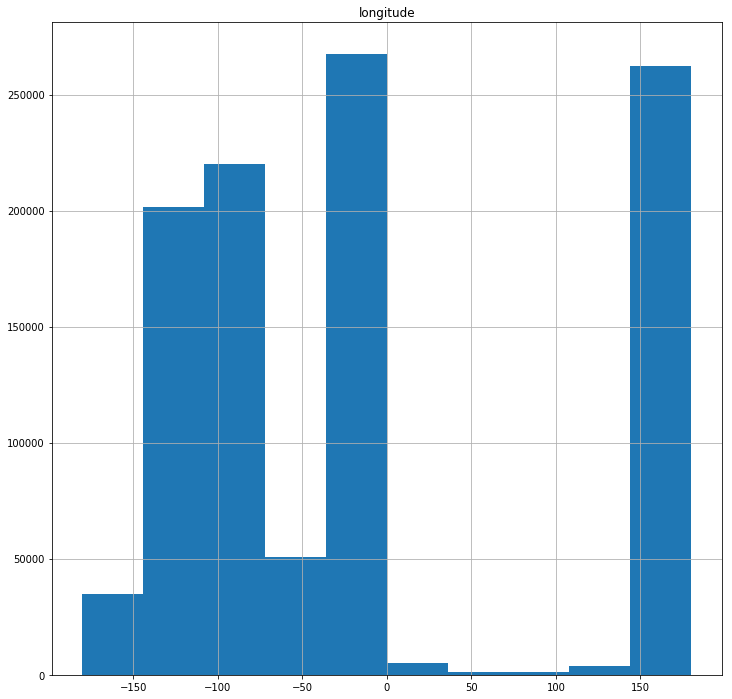

In [42]:
df.hist('longitude')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fafd284c9e8>]], dtype=object)

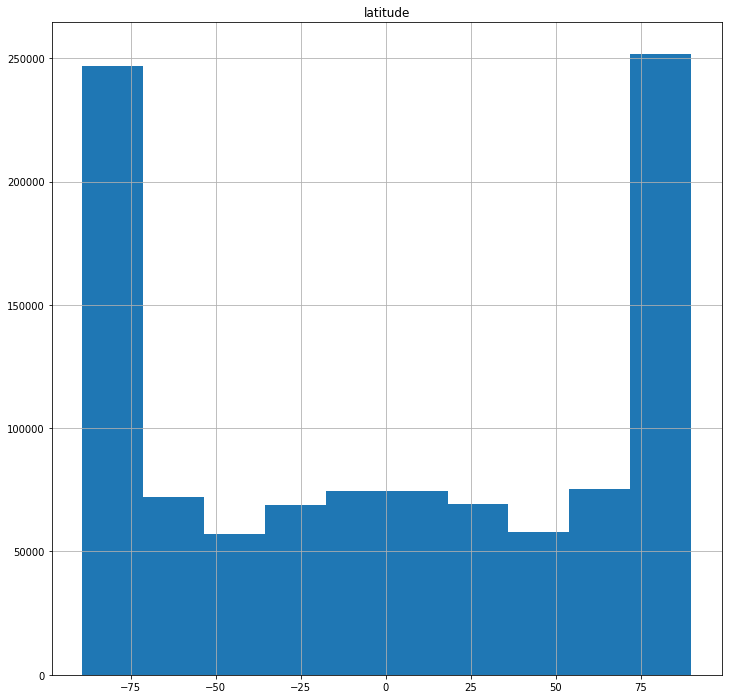

In [43]:
df.hist('latitude')

# Illumination Direction (Sort of)

In [19]:
model.illumination_direction([0,0,282]) # 'north' poleish

[72584382155.74005, 131469457446.03712, 4308117605.711538]

# Now convert from Lat/Lon/DN into an interpolated raster

Modified from: http://gis.stackexchange.com/questions/177061/ascii-file-with-latitude-longitude-and-data-to-geotiff-using-python

In [20]:
import matplotlib.mlab as ml
# create grid
xmin, xmax, ymin, ymax = [min(df.longitude), max(df.longitude),
                          min(df.latitude), max(df.latitude)]
row, col = model.imagesize
xi = np.linspace(xmin, xmax, col)
yi = np.linspace(ymin, ymax, row)
xi, yi = np.meshgrid(xi, yi)

# linear interpolation
zi = ml.griddata(df.longitude, df.latitude, df.dn, xi, yi, interp='linear')
final_array = np.asarray(np.rot90(np.transpose(zi)))

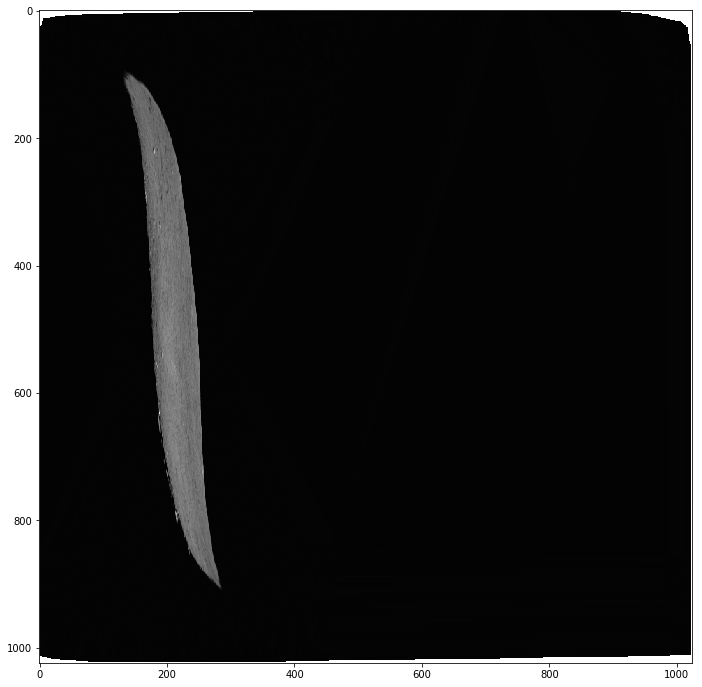

In [21]:
figsize(12,12)
imshow(final_array, cmap='gray')